# Dataset Description
You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

This notebook will use Machine Learning methods only: Logistic Regression, LinearSVM, and Naive Bayes with TF-IDF

In [1]:
import os
import zipfile

zip_files = [
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
]

extract_base_folder = '/kaggle/working/jigsaw-toxic-comment-classification-challenge'

os.makedirs(extract_base_folder, exist_ok=True)

for zip_file in zip_files:
    extract_folder = os.path.join(extract_base_folder, os.path.splitext(os.path.basename(zip_file))[0])
    
    if not os.path.exists(extract_folder):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"Extracted {zip_file} to {extract_folder}")
    else:
        print(f"Skipping {zip_file}, {extract_folder} already exists.")

Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/test.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/test_labels.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/train.csv


# **Import modules**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Load the dataset**

In [3]:
df = pd.read_csv('/kaggle/working/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


- Check for null values

In [6]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# **Kiểm tra các comment chưa được gán nhãn**

In [7]:
x = df.iloc[:, 2:].sum() # Chỉ lấy các cột label
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [8]:
rowsums = df.iloc[:, 2:].sum(axis=1) # Lấy các cột label và tính tổng theo từng cột
rowsums

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

In [9]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1
        
print('Tổng số lượng comments: ', len(df))
print('Số lượng comment chưa được gán nhãn: ', no_label_count)
print('Số lượng label ', x.sum())

Tổng số lượng comments:  159571
Số lượng comment chưa được gán nhãn:  143346
Số lượng label  35098


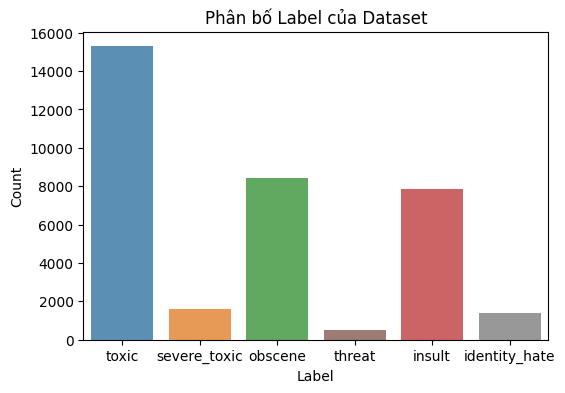

In [10]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Label của Dataset')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

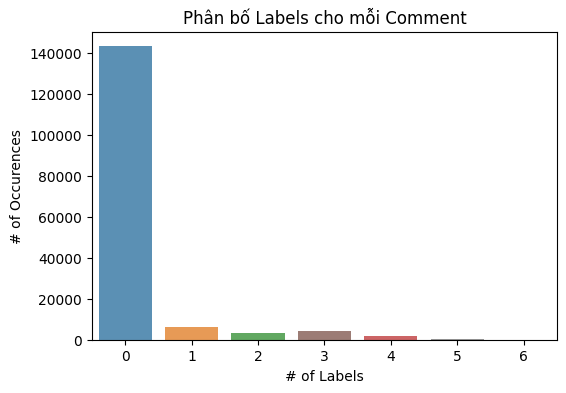

In [11]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Labels cho mỗi Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

# **Data Preprocessing**

In [12]:
df = df.drop(columns=['id'], axis=1) # Drop cột id

In [13]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## **Fill các giá trị NaN (nếu có)**

In [14]:
# Fill NaN
df['comment_text'] = df['comment_text'].fillna('').astype(str)

## **Loại bỏ Stopwords**

In [15]:
# Set STOPWORDS
STOPWORDS = set(stopwords.words('english'))

In [16]:
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if w not in STOPWORDS]
    return " ".join(no_stopword_text)

## **Làm sạch text**

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

## **Stemming**

In [18]:
stemmer = SnowballStemmer('english')

def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [19]:
df['comment_text'] = df['comment_text'].apply(remove_stopwords)
df['comment_text'] = df['comment_text'].apply(clean_text)
df['comment_text'] = df['comment_text'].apply(stemming)

In [20]:
df.head(15)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0,0,0,0
5,congratul well use tool well talk,0,0,0,0,0,0
6,cocksuck befor you piss around on my work,1,1,1,0,1,0
7,your vandal matt shirvington articl revert ple...,0,0,0,0,0,0
8,sorri word nonsens offens you anyway i am inte...,0,0,0,0,0,0
9,align subject contrari dulithgow,0,0,0,0,0,0


In [21]:
# Các cột label gốc cho multi-label classification
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Binary target: comment được coi là toxic nếu có ÍT NHẤT một trong các label trên = 1
df["any_toxic"] = (df[label_cols].max(axis=1) > 0).astype(int)

# **Split data**

In [22]:
# Binary classification: any_toxic và non-toxic
X_bin = df["comment_text"]
y_bin = df["any_toxic"]

# Multi-label classification
X_multi = df["comment_text"]
Y_multi = df[label_cols]

In [23]:
# Binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin,
    test_size=0.2,
    random_state=42,
    stratify=y_bin
)

# Multi-label classification
X_train_multi, X_test_multi, Y_train_multi, Y_test_multi = train_test_split(
    X_multi, Y_multi,
    test_size=0.2,
    random_state=42
)

# **Training**

## **Hàm vẽ Confusion Matrix và ROC-Curve**

In [24]:
# ---- Binary: Confusion Matrix ----
def plot_confusion_matrix_binary(y_true, y_pred, title="Confusion Matrix (binary)"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- Binary: ROC Curve ----
def plot_roc_curve_binary(y_true, y_scores, title="ROC Curve (binary)"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [25]:
# ---- Multi-label: Confusion Matrices cho từng label ----
def plot_confusion_matrices_multilabel(Y_true, Y_pred, label_names):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    n_labels = len(label_names)

    n_cols = 3
    n_rows = int(np.ceil(n_labels / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.ravel()

    for i, label in enumerate(label_names):
        cm = confusion_matrix(Y_true[:, i], Y_pred[:, i])
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
            ax=axes[i]
        )
        axes[i].set_title(label)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    # Ẩn axes thừa (nếu n_labels không chia hết cho n_cols)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# ---- Multi-label: ROC Curves cho từng label ----
def plot_roc_curves_multilabel(Y_true, Y_scores, label_names, title_prefix="ROC (multi-label)"):
    Y_true = np.asarray(Y_true)
    Y_scores = np.asarray(Y_scores)
    n_labels = len(label_names)

    plt.figure(figsize=(6, 6))
    for i, label in enumerate(label_names):
        try:
            fpr, tpr, _ = roc_curve(Y_true[:, i], Y_scores[:, i])
            auc = roc_auc_score(Y_true[:, i], Y_scores[:, i])
            plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
        except ValueError:
            # Trường hợp label toàn 0 hoặc toàn 1 → không vẽ được ROC
            continue

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title_prefix)
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

## **Hàm pipeline cho Binary và Multi-label**

In [26]:
def run_binary(pipeline, model_name, X_train_bin, X_test_bin, y_train_bin, y_test_bin):
    print(f"\n=== {model_name} | Binary classification ===")
    
    # train
    pipeline.fit(X_train_bin, y_train_bin)
    
    # predict labels
    y_pred = pipeline.predict(X_test_bin)
    
    # predict scores for ROC-AUC
    if hasattr(pipeline, "predict_proba"):
        y_scores = pipeline.predict_proba(X_test_bin)
        # lấy xác suất lớp positive (cột 1)
        if y_scores.ndim == 2 and y_scores.shape[1] == 2:
            y_scores = y_scores[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_scores = pipeline.decision_function(X_test_bin)
    else:
        y_scores = None
    
    # metrics
    print("accuracy:", accuracy_score(y_test_bin, y_pred))
    print("f1_binary:", f1_score(y_test_bin, y_pred, average="binary"))
    print("precision:", precision_score(y_test_bin, y_pred, average="binary"))
    print("recall:", recall_score(y_test_bin, y_pred, average="binary"))
    
    if y_scores is not None:
        print("roc_auc:", roc_auc_score(y_test_bin, y_scores))
    
    print("\nclassification report:")
    print(classification_report(y_test_bin, y_pred))
    
    print("confusion matrix (numbers):")
    print(confusion_matrix(y_test_bin, y_pred))
    
    # Plot confusion matrix
    plot_confusion_matrix_binary(y_test_bin, y_pred, title=f"{model_name} - Confusion Matrix")
    
    # Plot ROC curve
    if y_scores is not None:
        plot_roc_curve_binary(y_test_bin, y_scores, title=f"{model_name} - ROC Curve")

In [27]:
def run_multilabel(pipeline, model_name,
                   X_train_multi, X_test_multi,
                   Y_train_multi, Y_test_multi,
                   label_names):
    print(f"\n=== {model_name} | Multi-label classification ===")
    
    # train
    pipeline.fit(X_train_multi, Y_train_multi)
    
    # predict labels
    Y_pred = pipeline.predict(X_test_multi)
    
    # predict scores cho ROC-AUC
    if hasattr(pipeline, "predict_proba"):
        Y_scores = pipeline.predict_proba(X_test_multi)
    elif hasattr(pipeline, "decision_function"):
        Y_scores = pipeline.decision_function(X_test_multi)
    else:
        Y_scores = None
    
    # metrics
    print("accuracy (exact match):", accuracy_score(Y_test_multi, Y_pred))
    print("f1_micro:", f1_score(Y_test_multi, Y_pred, average="micro"))
    print("f1_macro:", f1_score(Y_test_multi, Y_pred, average="macro"))
    
    if Y_scores is not None:
        print("roc_auc_macro:", roc_auc_score(Y_test_multi, Y_scores, average="macro"))
    
    print("\nclassification report (per label):")
    print(classification_report(Y_test_multi, Y_pred, target_names=label_names))
    
    # Plot confusion matrices
    plot_confusion_matrices_multilabel(Y_test_multi, Y_pred, label_names)
    
    # Plot ROC curves
    if Y_scores is not None:
        plot_roc_curves_multilabel(Y_test_multi, Y_scores, label_names,
                                   title_prefix=f"{model_name} - ROC (per label)")

## **Pipeline cho Binary Classification**

In [28]:
# Multinomial Naive Bayes
NB_pipeline_bin = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', MultinomialNB())
])

# Logistic Regression
LR_pipeline_bin = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr_model', LogisticRegression(max_iter=1000))
])

# LinearSVM
SVM_pipeline_bin = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("svm_model", LinearSVC())
])


=== Logistic Regression (binary) | Binary classification ===
accuracy: 0.9556321478928403
f1_binary: 0.7396101507907319
precision: 0.9170086639306886
recall: 0.6197226502311248
roc_auc: 0.9711408982615523

classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28670
           1       0.92      0.62      0.74      3245

    accuracy                           0.96     31915
   macro avg       0.94      0.81      0.86     31915
weighted avg       0.95      0.96      0.95     31915

confusion matrix (numbers):
[[28488   182]
 [ 1234  2011]]


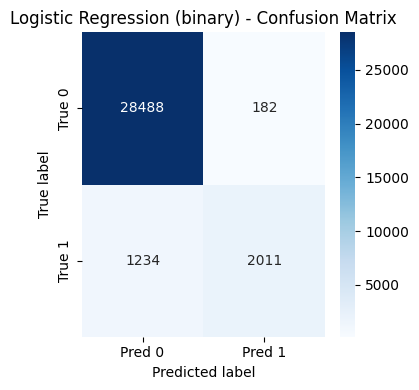

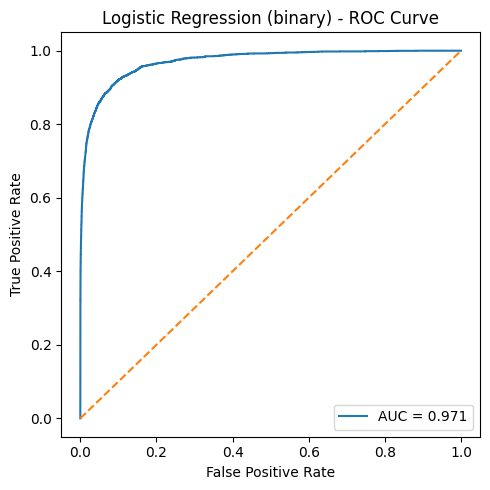

In [29]:
run_binary(
    LR_pipeline_bin,
    "Logistic Regression (binary)",
    X_train_bin, X_test_bin,
    y_train_bin, y_test_bin
)


=== Linear SVM (binary) | Binary classification ===
accuracy: 0.9604261319128936
f1_binary: 0.7848748083801738
precision: 0.8773800456968773
recall: 0.710015408320493
roc_auc: 0.967372507837176

classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28670
           1       0.88      0.71      0.78      3245

    accuracy                           0.96     31915
   macro avg       0.92      0.85      0.88     31915
weighted avg       0.96      0.96      0.96     31915

confusion matrix (numbers):
[[28348   322]
 [  941  2304]]


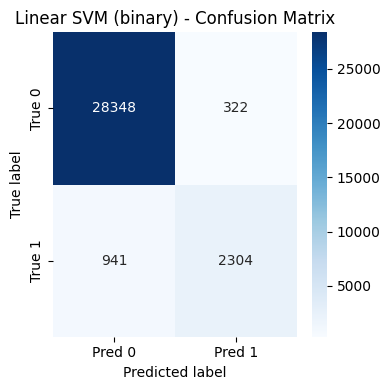

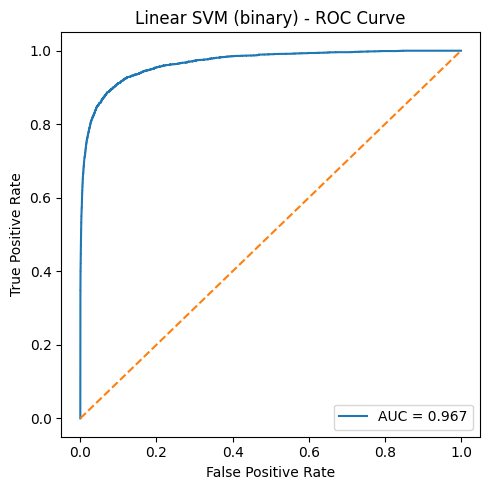

In [30]:
run_binary(
    SVM_pipeline_bin,
    "Linear SVM (binary)",
    X_train_bin, X_test_bin,
    y_train_bin, y_test_bin
)


=== MultinomialNB (binary) | Binary classification ===
accuracy: 0.9200689331035563
f1_binary: 0.3540136743479362
precision: 0.9928977272727273
recall: 0.21540832049306627
roc_auc: 0.8908108581633735

classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28670
           1       0.99      0.22      0.35      3245

    accuracy                           0.92     31915
   macro avg       0.96      0.61      0.66     31915
weighted avg       0.93      0.92      0.90     31915

confusion matrix (numbers):
[[28665     5]
 [ 2546   699]]


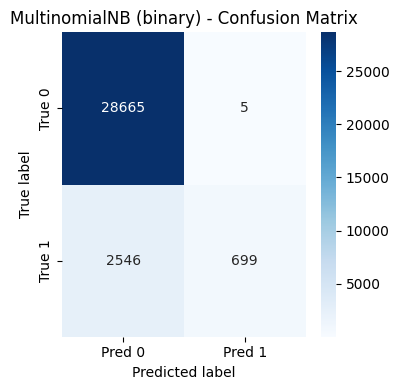

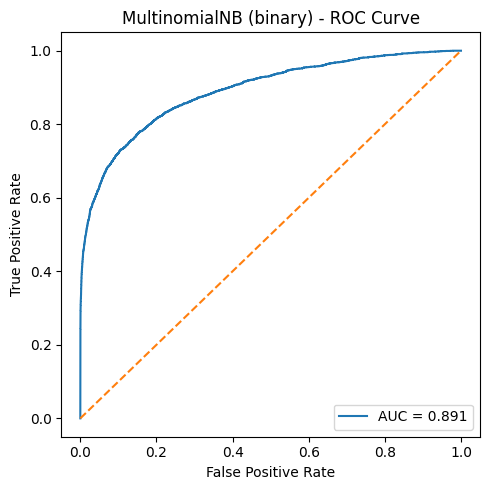

In [31]:
run_binary(
    NB_pipeline_bin,
    "MultinomialNB (binary)",
    X_train_bin, X_test_bin,
    y_train_bin, y_test_bin
)

## **Pipeline cho Multi-label**

In [32]:
# MultinomialNB (OneVsRest)
NB_pipeline_multi = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

# Logistic Regression (OneVsRest)
LR_pipeline_multi = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr_model', OneVsRestClassifier(LogisticRegression(max_iter=1000), n_jobs=-1))
])

# Multi-label: LinearSVC (OneVsRest)
SVM_pipeline_multi = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))
])



=== Logistic Regression (multi-label) | Multi-label classification ===
accuracy (exact match): 0.9187216042613191
f1_micro: 0.6820929027801761
f1_macro: 0.49914268634342424
roc_auc_macro: 0.9794842404472256

classification report (per label):
               precision    recall  f1-score   support

        toxic       0.91      0.62      0.74      3056
 severe_toxic       0.58      0.28      0.38       321
      obscene       0.92      0.64      0.75      1715
       threat       0.69      0.15      0.24        74
       insult       0.81      0.51      0.62      1614
identity_hate       0.72      0.16      0.26       294

    micro avg       0.88      0.56      0.68      7074
    macro avg       0.77      0.39      0.50      7074
 weighted avg       0.87      0.56      0.67      7074
  samples avg       0.06      0.05      0.05      7074



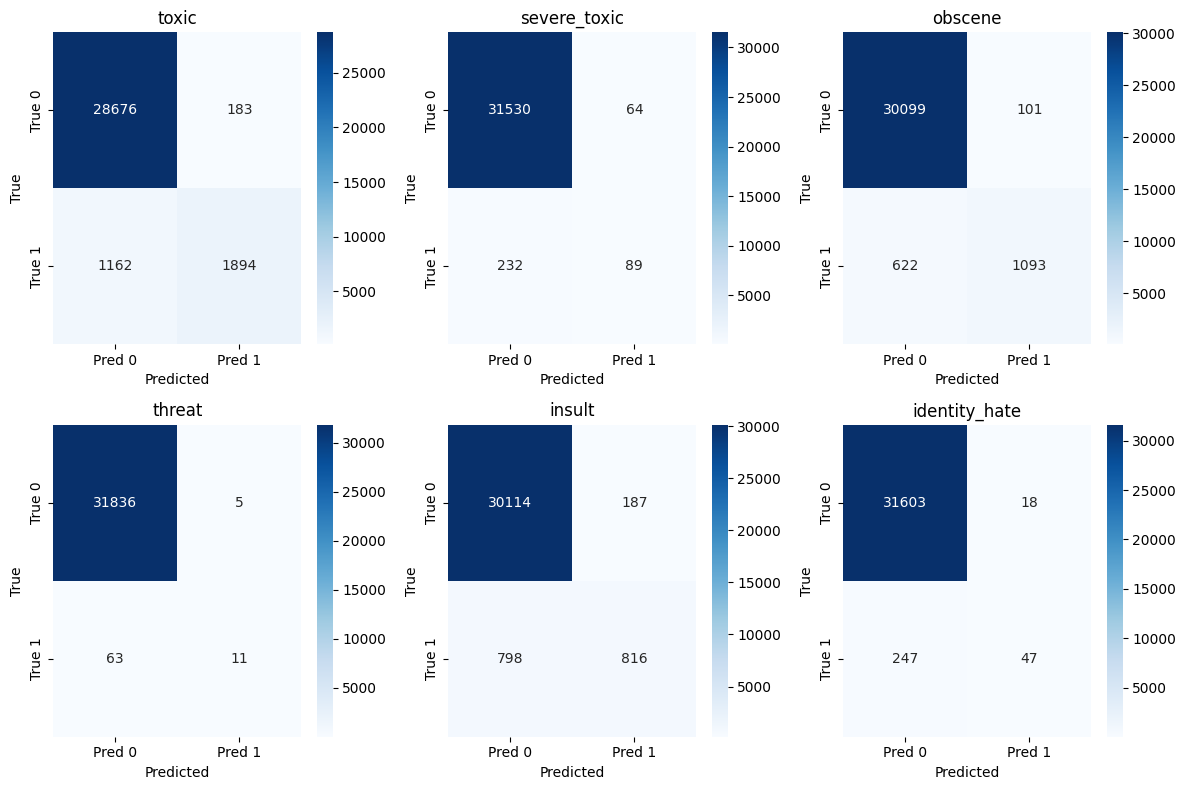

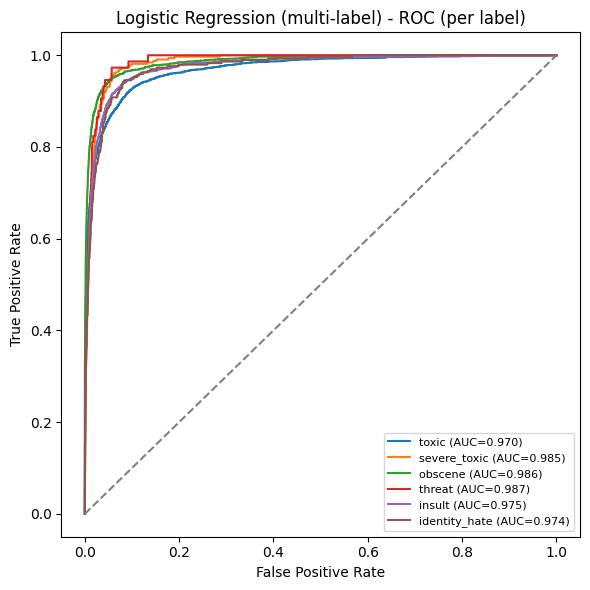

In [33]:
run_multilabel(
    LR_pipeline_multi,
    "Logistic Regression (multi-label)",
    X_train_multi, X_test_multi,
    Y_train_multi, Y_test_multi,
    label_cols
)


=== Linear SVM (multi-label) | Multi-label classification ===
accuracy (exact match): 0.9195676014413285
f1_micro: 0.7216893689046505
f1_macro: 0.5544537011032745
roc_auc_macro: 0.9703936767696222

classification report (per label):
               precision    recall  f1-score   support

        toxic       0.87      0.70      0.77      3056
 severe_toxic       0.55      0.32      0.40       321
      obscene       0.89      0.71      0.79      1715
       threat       0.55      0.23      0.32        74
       insult       0.79      0.58      0.67      1614
identity_hate       0.69      0.25      0.37       294

    micro avg       0.84      0.63      0.72      7074
    macro avg       0.72      0.46      0.55      7074
 weighted avg       0.83      0.63      0.71      7074
  samples avg       0.06      0.06      0.06      7074



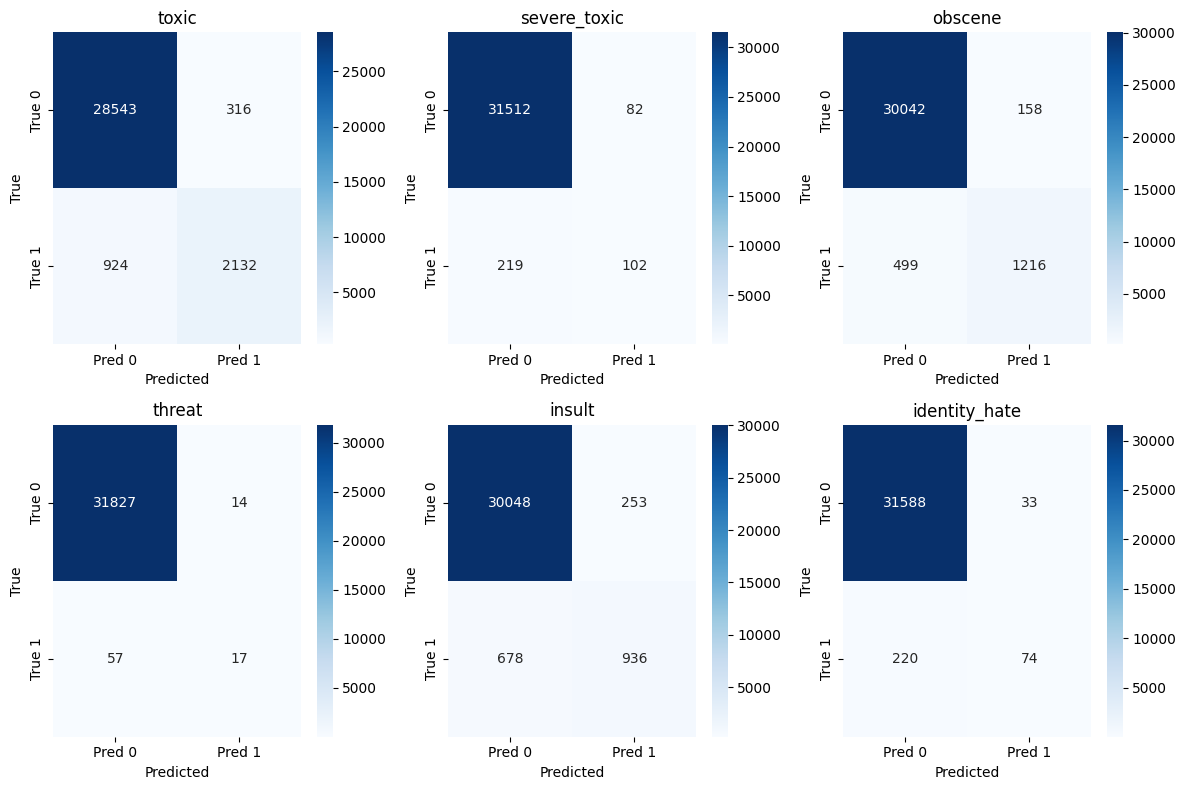

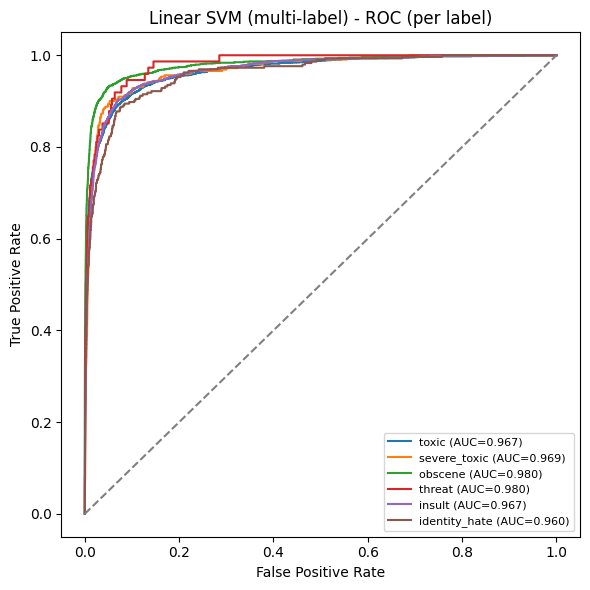

In [34]:
run_multilabel(
    SVM_pipeline_multi,
    "Linear SVM (multi-label)",
    X_train_multi, X_test_multi,
    Y_train_multi, Y_test_multi,
    label_cols
)


=== MultinomialNB (multi-label) | Multi-label classification ===
accuracy (exact match): 0.8997963340122199
f1_micro: 0.215706015605336
f1_macro: 0.10790726044839359
roc_auc_macro: 0.8604178106899295

classification report (per label):
               precision    recall  f1-score   support

        toxic       0.99      0.19      0.32      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.98      0.11      0.20      1715
       threat       1.00      0.01      0.03        74
       insult       0.97      0.05      0.10      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.12      0.22      7074
    macro avg       0.66      0.06      0.11      7074
 weighted avg       0.90      0.12      0.21      7074
  samples avg       0.02      0.01      0.01      7074



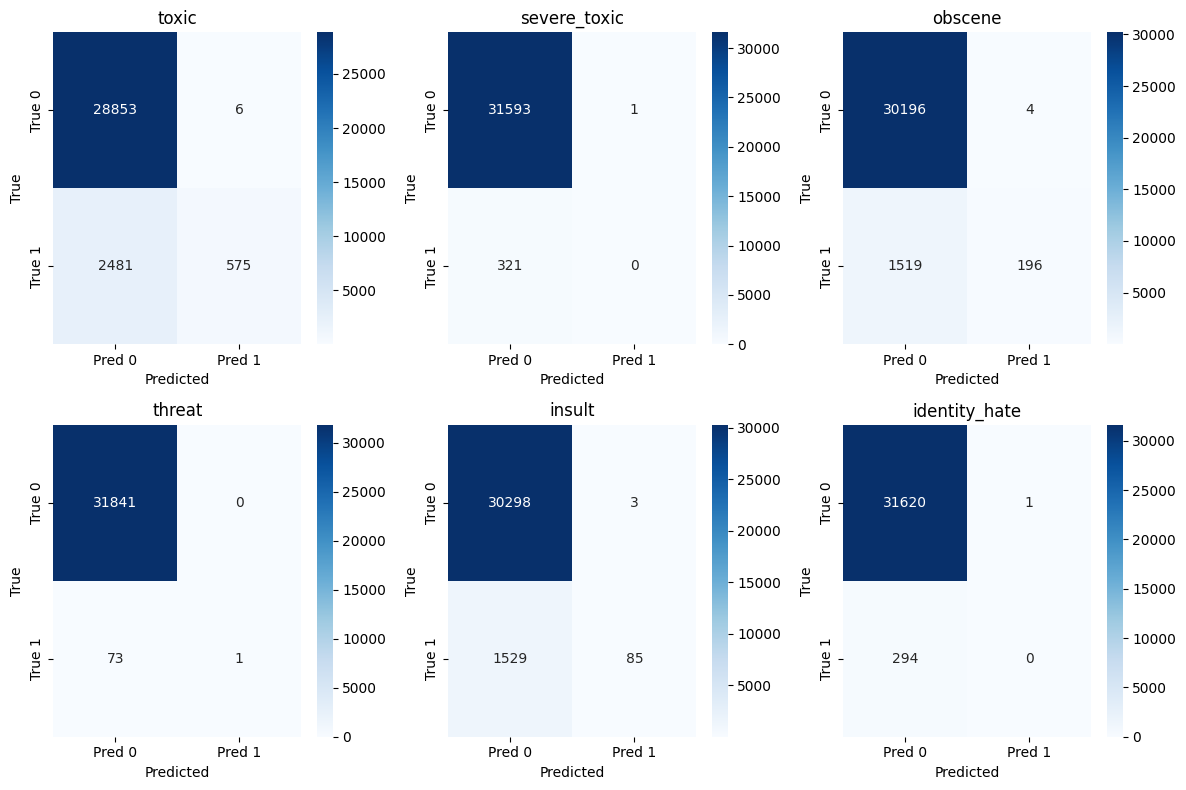

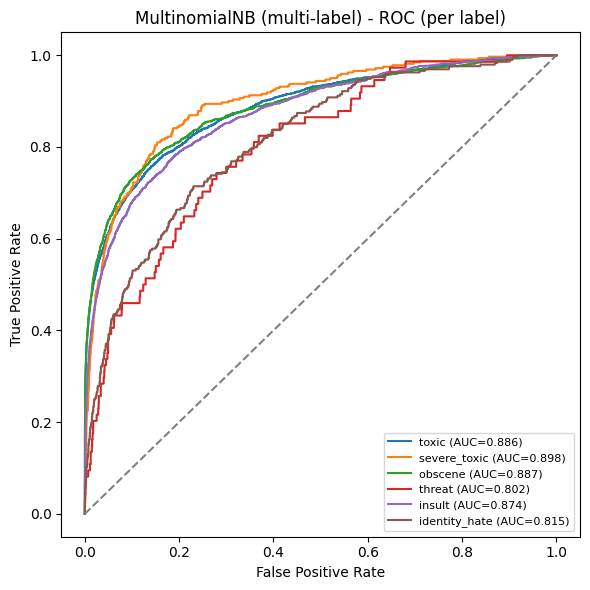

In [35]:
run_multilabel(
    NB_pipeline_multi,
    "MultinomialNB (multi-label)",
    X_train_multi, X_test_multi,
    Y_train_multi, Y_test_multi,
    label_cols
)

# **Test Prediction**

In [36]:
test_path = "/kaggle/working/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv"

In [37]:
test_df = pd.read_csv(test_path)
test_df.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [38]:
# Xử lý NaN
test_df["comment_text"] = test_df["comment_text"].fillna("").astype(str)

# xóa stopwords -> làm sạch text -> stemming
test_df["comment_text"] = test_df["comment_text"].apply(remove_stopwords)
test_df["comment_text"] = test_df["comment_text"].apply(clean_text)
test_df["comment_text"] = test_df["comment_text"].apply(stemming)

test_df.head(10)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succes ever what hate sad mof...
1,0000247867823ef7,from rfc the titl fine is imo
2,00013b17ad220c46,sourc zaw ashton lapland
3,00017563c3f7919a,if look back sourc inform i updat correct form...
4,00017695ad8997eb,i anonym edit articl all
5,0001ea8717f6de06,thank understand i think high would revert wit...
6,00024115d4cbde0f,pleas add nonsens wikipedia such edit consid v...
7,000247e83dcc1211,dear god site horribl
8,00025358d4737918,onli fool believ number the correct number lie...
9,00026d1092fe71cc,doubl redirect when fix doubl redirect blank o...


In [39]:
label_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [40]:
# X là cột comment_text đã preproces
X_test_kaggle = test_df["comment_text"]

# Dự đoán xác suất cho từng label với mô hình tốt nhất (Logistic Regression)
test_probs = LR_pipeline_multi.predict_proba(X_test_kaggle)

In [41]:
# Tạo DataFrame submission
submission = pd.DataFrame(test_probs, columns=label_cols)

# Thêm cột id ở đầu để khớp với test.csv
submission.insert(0, "id", test_df["id"].values)

submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997975,0.160296,0.995252,0.037331,0.950221,0.248866
1,0000247867823ef7,0.009968,0.003399,0.006979,0.002085,0.009460,0.003751
2,00013b17ad220c46,0.046650,0.004945,0.018585,0.001942,0.021100,0.004534
3,00017563c3f7919a,0.002846,0.001868,0.002339,0.001046,0.002457,0.000767
4,00017695ad8997eb,0.007316,0.001140,0.004395,0.000951,0.005052,0.001405


In [42]:
submission_file = "submission.csv"
submission.to_csv(submission_file, index=False)

print("Saved:", submission_file)
print(submission.head())

Saved: submission.csv
                 id     toxic  severe_toxic   obscene    threat    insult  \
0  00001cee341fdb12  0.997975      0.160296  0.995252  0.037331  0.950221   
1  0000247867823ef7  0.009968      0.003399  0.006979  0.002085  0.009460   
2  00013b17ad220c46  0.046650      0.004945  0.018585  0.001942  0.021100   
3  00017563c3f7919a  0.002846      0.001868  0.002339  0.001046  0.002457   
4  00017695ad8997eb  0.007316      0.001140  0.004395  0.000951  0.005052   

   identity_hate  
0       0.248866  
1       0.003751  
2       0.004534  
3       0.000767  
4       0.001405  


# **Lưu mô hình**

In [43]:
import joblib

# Save binary models
joblib.dump(NB_pipeline_bin,  "nb_binary.joblib")
joblib.dump(LR_pipeline_bin,  "lr_binary.joblib")
joblib.dump(SVM_pipeline_bin, "svm_binary.joblib")

# Save multi-label models
joblib.dump(NB_pipeline_multi,  "nb_multilabel.joblib")
joblib.dump(LR_pipeline_multi,  "lr_multilabel.joblib")
joblib.dump(SVM_pipeline_multi, "svm_multilabel.joblib")

print("Saved 6 models:")
print("  nb_binary.joblib")
print("  lr_binary.joblib")
print("  svm_binary.joblib")
print("  nb_multilabel.joblib")
print("  lr_multilabel.joblib")
print("  svm_multilabel.joblib")

Saved 6 models:
  nb_binary.joblib
  lr_binary.joblib
  svm_binary.joblib
  nb_multilabel.joblib
  lr_multilabel.joblib
  svm_multilabel.joblib
